### Gráficos
- número de veces que una heurística fue la mejor
- cantidad de clientes vs tiempo (para cada heurística)
- distancia al óptimo, promedio (para cada heurística, en instancias donde tengamos el óptimo)
- cuánto mejora aplicar búsqueda local a cada heurística, en promedio (porcentaje)
- scatter plot: costo vs tiempo
    -  cada punto es un (heuristic, instance)
    - símbolos distintos para cada heurística

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
# Load data
df = pd.read_csv('/Users/nicogalindez/UTDT/TD5/TD5-TP2/experiments/results/output.csv')

# Create 'combination' column, but remove '+none' or 'none+' if present
def clean_combination(row):
    heuristic = row['heuristic']
    local_search = row['local_search']
    if local_search == 'none':
        return heuristic
    elif heuristic == 'none':
        return local_search
    else:
        return heuristic + '+' + local_search

df['combination'] = df.apply(clean_combination, axis=1)

# Reorder columns so 'combination' is after 'num_clientes'
cols = list(df.columns)
if 'combination' in cols and 'num_clientes' in cols:
    cols.remove('combination')
    idx = cols.index('num_clientes') + 1
    cols = cols[:idx] + ['combination'] + cols[idx:]
    df = df[cols]

# df_ok va a tener los casos que tienen soluciones factibles
df_ok = df[df['status'] == 'ok'].copy()

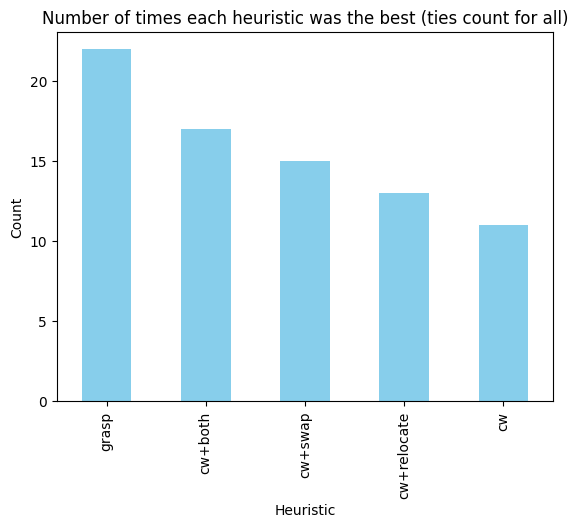

In [67]:
# For each instance, find all rows with the minimum cost among feasible solutions (handle ties)
best_counts = {}

for instance, group in df_ok.groupby('instance'):
    min_cost = group['cost'].min()
    winners = group[group['cost'] == min_cost]['combination']
    for comb in winners:
        best_counts[comb] = best_counts.get(comb, 0) + 1

# Convert to Series for plotting
best_counts_series = pd.Series(best_counts).sort_values(ascending=False)

# Plot
best_counts_series.plot(kind='bar', color='skyblue')
plt.title('Number of times each heuristic was the best (ties count for all)')
plt.xlabel('Heuristic')
plt.ylabel('Count')
plt.show()

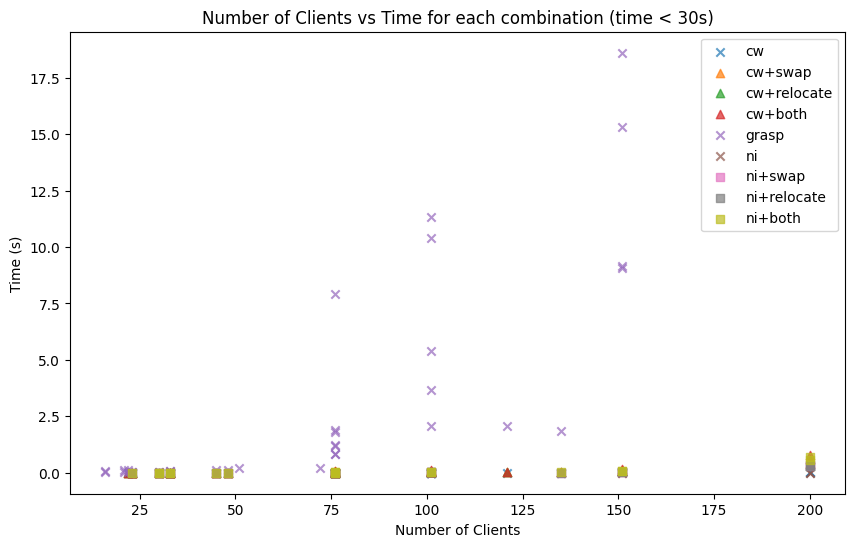

In [68]:
# Plot time vs number of clients with different shapes for cw, ni, grasp
# Only use those that took less than 30s

plt.figure(figsize=(10,6))

# Filter to only those with time < 30s
df_fast = df_ok[df_ok['time'] < 30]

# Define marker shapes for each family (make them different)
marker_map = {
    'cw': '^',      # triangle up
    'ni': 's',      # square
    'grasp': 'D',   # diamond
    'ic': 'o',      # circle
    'other': 'x'    # x for any other
}

def get_family(combination):
    if combination.startswith('cw+'):
        return 'cw'
    elif combination.startswith('ni+'):
        return 'ni'
    elif combination.startswith('grasp+'):
        return 'grasp'
    elif combination.startswith('ic+'):
        return 'ic'
    else:
        return 'other'

# Assign a marker for each combination, using different shapes for each family
for combination in df_fast['combination'].unique():
    subset = df_fast[df_fast['combination'] == combination]
    family = get_family(combination)
    marker = marker_map.get(family, marker_map['other'])  # default to 'x' if not found
    plt.scatter(subset['num_clientes'], subset['time'], label=combination, alpha=0.7, marker=marker)

plt.xlabel('Number of Clients')
plt.ylabel('Time (s)')
plt.title('Number of Clients vs Time for each combination (time < 30s)')
plt.legend()
plt.show()

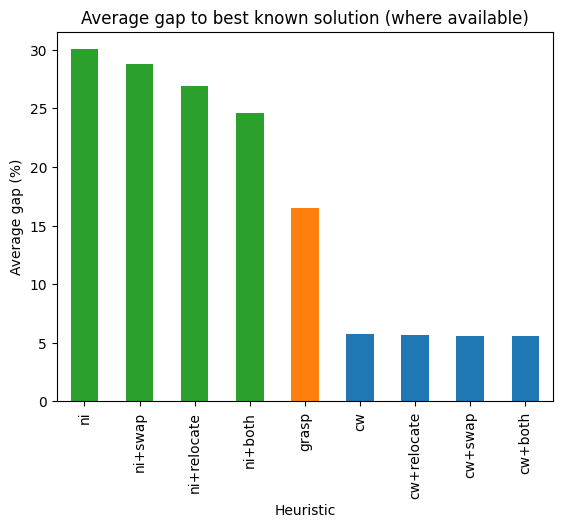

In [70]:
# Only consider rows where 'gap' and 'best_known' are not NaN
df_gap = df_ok.dropna(subset=['gap', 'best_known'])

# Compute average gap per combination
avg_gap = df_gap.groupby('combination')['gap'].mean()

# Sort from biggest to smallest
avg_gap = avg_gap.sort_values(ascending=False)

# Assign a color for each base heuristic
base_colors = {
    'cw': '#1f77b4',      # blue
    'ni': '#2ca02c',      # green
    'grasp': '#ff7f0e',   # orange
    'other': '#7f7f7f'    # gray
}

def get_family(combination):
    if combination.startswith('cw'):
        return 'cw'
    elif combination.startswith('ni'):
        return 'ni'
    elif combination.startswith('grasp'):
        return 'grasp'
    else:
        return 'other'

# Build color list for each bar
bar_colors = [base_colors.get(get_family(comb), base_colors['other']) for comb in avg_gap.index]

# Plot
avg_gap.plot(kind='bar', color=bar_colors)
plt.title('Average gap to best known solution (where available)')
plt.xlabel('Heuristic')
plt.ylabel('Average gap (%)')
plt.show()

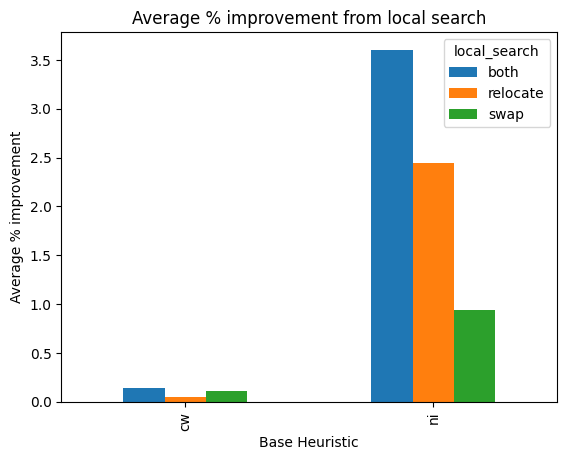

In [ ]:
# For each heuristic (base), for each instance, compare 'none' vs 'swap', 'relocate', 'both'
improvements = []
# Extract base heuristic from combination (before '+')
df_ok['base_heuristic'] = df_ok['combination'].str.split('+').str[0]

for base_heuristic in df_ok['base_heuristic'].unique():
    for instance in df_ok['instance'].unique():
        base = df_ok[
            (df_ok['base_heuristic'] == base_heuristic) &
            (df_ok['instance'] == instance) &
            (df_ok['local_search'] == 'none')
        ]
        for ls in ['swap', 'relocate', 'both']:
            improved = df_ok[
                (df_ok['base_heuristic'] == base_heuristic) &
                (df_ok['instance'] == instance) &
                (df_ok['local_search'] == ls)
            ]
            if not base.empty and not improved.empty:
                base_cost = base.iloc[0]['cost']
                improved_cost = improved.iloc[0]['cost']
                if pd.notnull(base_cost) and pd.notnull(improved_cost) and base_cost > 0:
                    improvement = 100 * (base_cost - improved_cost) / base_cost
                    improvements.append({
                        'base_heuristic': base_heuristic,
                        'local_search': ls,
                        'improvement': improvement
                    })

improv_df = pd.DataFrame(improvements)
if not improv_df.empty:
    avg_improv = improv_df.groupby(['base_heuristic', 'local_search'])['improvement'].mean().unstack()
    avg_improv.plot(kind='bar')
    plt.title('Average % improvement from local search')
    plt.ylabel('Average % improvement')
    plt.xlabel('Base Heuristic')
    plt.show()
else:
    print("No improvements to show (no matching data found).")

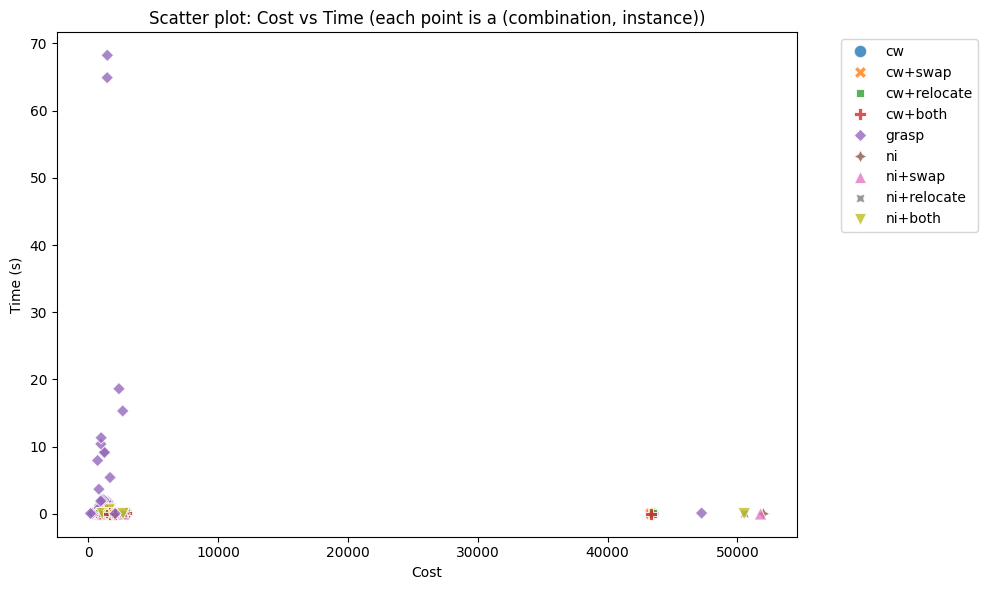

In [73]:
import seaborn as sns

# Ensure 'combination' column exists
if 'combination' not in df_ok.columns:
    df_ok['combination'] = df_ok['heuristic'] + '+' + df_ok['local_search']

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_ok,
    x='cost',
    y='time',
    hue='combination',
    style='combination',
    alpha=0.8,
    s=80
)
plt.title('Scatter plot: Cost vs Time (each point is a (combination, instance))')
plt.xlabel('Cost')
plt.ylabel('Time (s)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

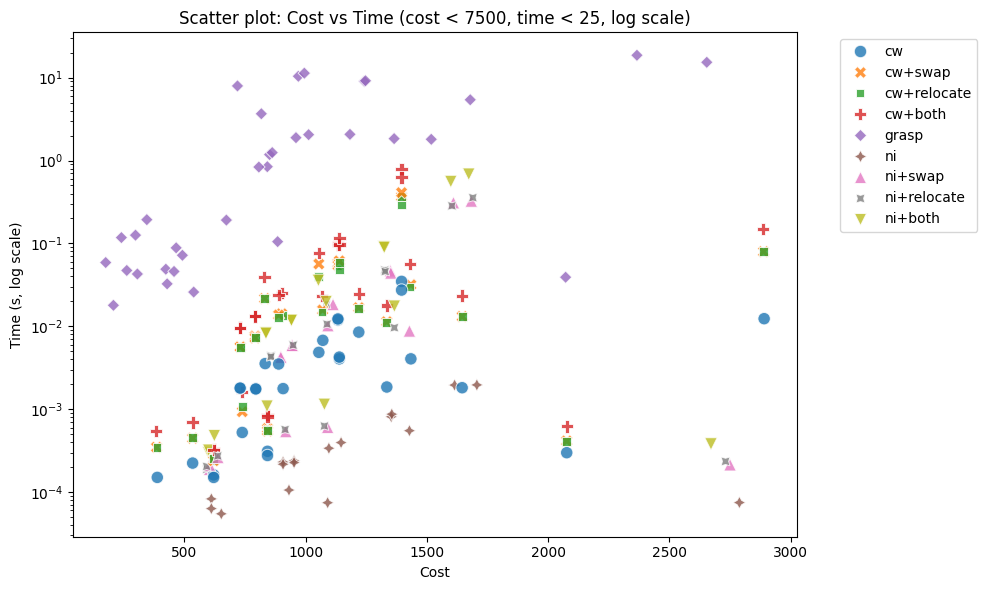

In [74]:
import seaborn as sns

# Ensure 'combination' column exists
if 'combination' not in df_ok.columns:
    df_ok['combination'] = df_ok['heuristic'] + '+' + df_ok['local_search']

# Restrict data for costs < 7500 and time < 25
filtered_df = df_ok[(df_ok['cost'] < 7500) & (df_ok['time'] < 25)]

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=filtered_df,
    x='cost',
    y='time',
    hue='combination',
    style='combination',
    alpha=0.8,
    s=80
)
ax.set_yscale('log')
plt.title('Scatter plot: Cost vs Time (cost < 7500, time < 25, log scale)')
plt.xlabel('Cost')
plt.ylabel('Time (s, log scale)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

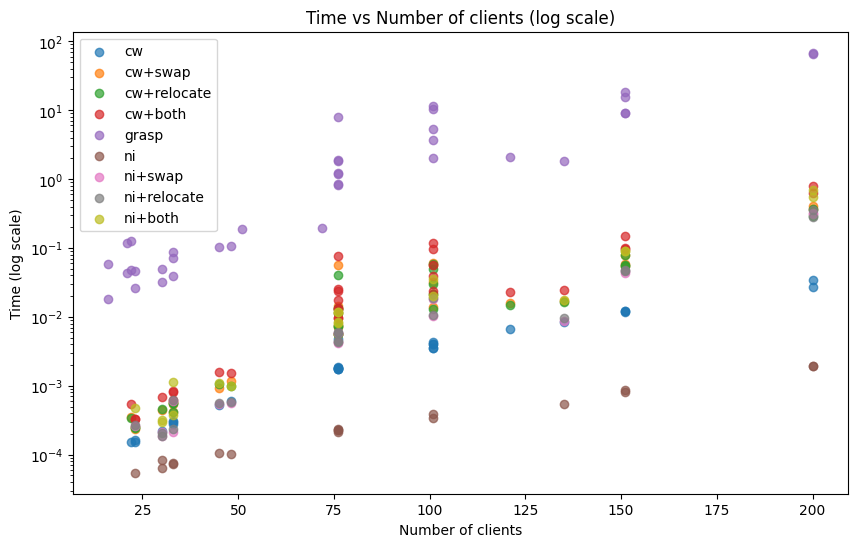

In [75]:
plt.figure(figsize=(10,6))
for comb in df_ok['combination'].unique():
    subset = df_ok[df_ok['combination'] == comb]
    plt.scatter(subset['num_clientes'], subset['time'], label=comb, alpha=0.7)
plt.yscale('log')
plt.xlabel('Number of clients')
plt.ylabel('Time (log scale)')
plt.title('Time vs Number of clients (log scale)')
plt.legend()
plt.show()

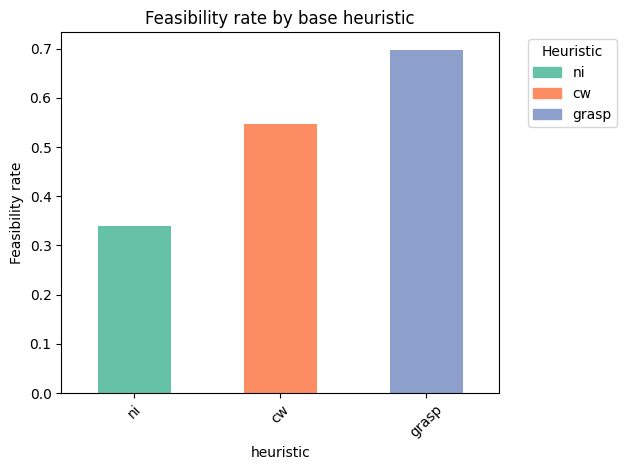

In [76]:
# Feasibility rate by base heuristic (not by combination)
import matplotlib.colors as mcolors

# Compute feasibility rate by base heuristic
feasibility_by_heuristic = df.groupby('heuristic')['status'].apply(lambda x: (x == 'ok').mean())

# Sort feasibility by value (increasingly)
feasibility_sorted = feasibility_by_heuristic.sort_values(ascending=True)
heuristics_sorted = feasibility_sorted.index.tolist()

# Pick a color palette
palette = sns.color_palette("Set2", n_colors=len(heuristics_sorted))
heuristic_to_color = dict(zip(heuristics_sorted, palette))
bar_colors = [heuristic_to_color[h] for h in heuristics_sorted]

feasibility_sorted.plot(kind='bar', color=bar_colors)
plt.title('Feasibility rate by base heuristic')
plt.ylabel('Feasibility rate')
plt.xticks(rotation=45)
# Add legend for heuristics (optional, since x-axis is heuristics)
handles = [plt.Rectangle((0,0),1,1, color=heuristic_to_color[h]) for h in heuristics_sorted]
plt.legend(handles, heuristics_sorted, title="Heuristic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()